# Imports & Configuration

## Installations

In [0]:
%pip install geopandas

  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/54/e4/fac19dc34cb686c96011388b813ff7b858a70681e5ce6ce7698e5021b0f4/geopandas-1.1.2-py3-none-any.whl.metadata
  Obtaining dependency information for numpy>=1.24 from https://files.pythonhosted.org/packages/5d/9d/7862db06743f489e6a502a3b93136d73aea27d97b2cf91504f70a27501d6/numpy-2.4.1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for pyogrio>=0.7.2 from https://files.pythonhosted.org/packages/89/a4/0aef5837b4e11840f501e48e01c31242838476c4f4aff9c05e228a083982/pyogrio-0.12.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for pandas>=2.0.0 from https://files.pythonhosted.org/packages/62/fb/89319812eb1d714bfc04b7f177895caeba8ab4a37ef6712db75ed786e2e0/pandas-3.0.0-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/79.5 kB ? eta -:--:--
     ━

## Settings

In [0]:
# Imports
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, lit, broadcast, rand, count, when
from delta.tables import DeltaTable

# Parameters
OVERTURE_PATH = "wasbs://release@overturemapswestus2.blob.core.windows.net/2025-12-17.0/theme=places/type=place"
OUTPUT_TABLE = "Itav_World_POIs"
CATEGORIES_CONFIG = {
    "nightlife": ['nightclub', 'bar', 'pub', 'casino', 'comedy_club', 'jazz_club', 'biergarten', 'karaoke_box', 'lounge'],
    "nature": ['national_park', 'nature_reserve', 'wildlife_refuge', 'waterfall', 'hot_spring', 'glacier', 'volcano', 'forest', 'mountain_peak', 'wetland'],
    "tourist": ['museum', 'aquarium', 'zoo', 'theme_park', 'water_park', 'castle', 'palace', 'archaeological_site', 'ruins', 'pagoda', 'planetarium', 'observatory'],
    "shopping": ['shopping_mall', 'outlet_store', 'marketplace', 'department_store', 'flea_market', 'shopping_centre'],
    "relaxation": ['spa', 'sauna', 'thermal_bath', 'public_bath', 'resort', 'massage', 'beauty_salon', 'beach_resort']
}
CONFIDENCE_THRESHOLD = 0.80

print(f"Configuration loaded.")
print(f"Reading from: {OVERTURE_PATH}")
print(f"Categories configured: {list(CATEGORIES_CONFIG.keys())}")


Configuration loaded.
Reading from: wasbs://release@overturemapswestus2.blob.core.windows.net/2025-12-17.0/theme=places/type=place
Categories configured: ['nightlife', 'nature', 'tourist', 'shopping', 'relaxation']


## Configuration Inference

In [0]:
# Infere all tags
ALL_TAGS = [tag for tags in CATEGORIES_CONFIG.values() for tag in tags]

# Create mapping data frame
mapping_data = []
for category, tags in CATEGORIES_CONFIG.items():
    for tag in tags:
        mapping_data.append((tag, category))
mapping_schema = ["tag", "category"]
mapping_df = spark.createDataFrame(mapping_data, schema=mapping_schema)
display(mapping_df)

tag,category
nightclub,nightlife
bar,nightlife
pub,nightlife
casino,nightlife
comedy_club,nightlife
jazz_club,nightlife
biergarten,nightlife
karaoke_box,nightlife
lounge,nightlife
national_park,nature


# Data Ingestion

In [0]:
# Load Data
print("Acquiring data from Overture Maps...")
overture_df = spark.read.format("parquet").load(OVERTURE_PATH)
print("Data acquired from Overture Maps successfully.")

Acquiring data from Overture Maps...
Data acquired from Overture Maps successfully.


# Data Processing

## Initial Select

In [0]:
# Select relevant columns
core_df = overture_df.select("id", "names", "categories", "confidence", "bbox", "addresses", "sources")

## Filter

### Coordinates

In [0]:
# Filter out data with invalid coordinates
valid_coords_df = core_df.filter(
    col("bbox.ymin").isNotNull() & 
    col("bbox.xmin").isNotNull()
)

total_records = valid_coords_df.count()
print(f"Total valid coordinate records: {total_records}")

Total valid coordinate records: 72417241


Geospatial indexing relies entirely on valid latitude and longitude coordinates.<br>
Records missing this structural data cannot be mapped or recommended, making their removal a mandatory technical prerequisite before any further processing.

### Confidence

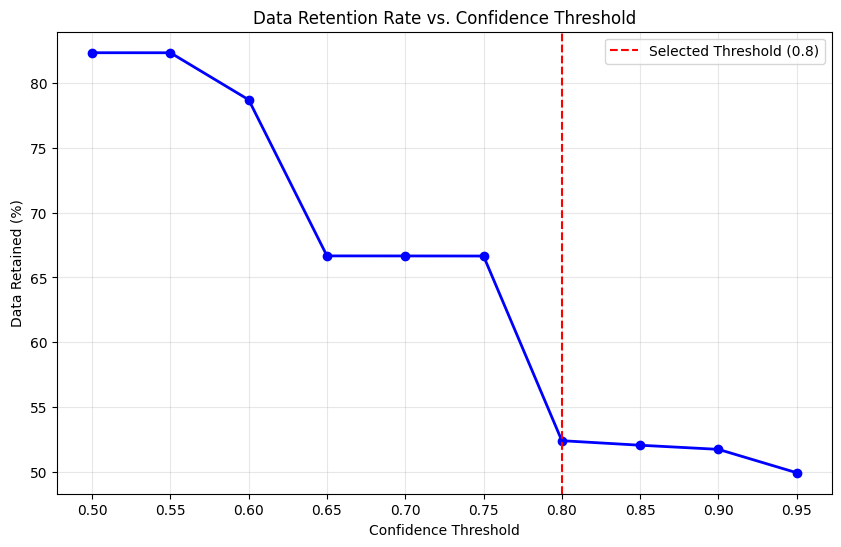

In [0]:
thresholds = np.arange(0.5, 1.0, 0.05)
counts = [{'Threshold': t, 'Retention Percentage': (valid_coords_df.filter(col("confidence") > t).count() / total_records) * 100} for t in thresholds]
pdf_curve = pd.DataFrame(counts)

plt.figure(figsize=(10, 6))
plt.plot(pdf_curve['Threshold'], pdf_curve['Retention Percentage'], marker='o', linestyle='-', color='b', linewidth=2)
plt.axvline(x=CONFIDENCE_THRESHOLD, color='r', linestyle='--', label=f'Selected Threshold ({CONFIDENCE_THRESHOLD})')
plt.title('Data Retention Rate vs. Confidence Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('Data Retained (%)')
min_diff = min([j - i for i, j in zip(thresholds[:-1], thresholds[1:])])
xticks = [round(thresholds[0] + i * min_diff, 2) for i in range(int((thresholds[-1] - thresholds[0]) / min_diff) + 1)]
plt.xticks(xticks)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

The curve illustrates the percentage of data retained at various confidence thresholds.<br>
The 'elbow' at 0.80 indicates the point of diminishing returns, where raising the threshold further causes significant data loss without proportionally gaining quality.

---

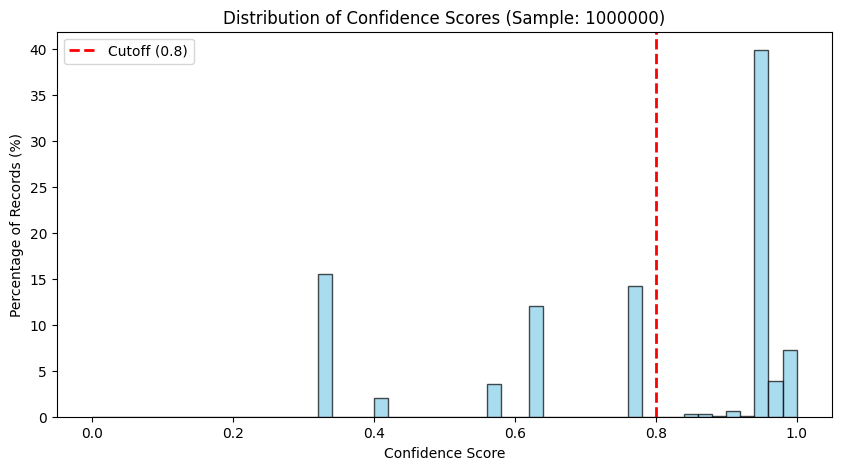

In [0]:
limit_size = 1000000
sample_conf = valid_coords_df.select("confidence").orderBy(rand()).limit(limit_size).toPandas()

plt.figure(figsize=(10, 5))
weights = np.ones(len(sample_conf)) / len(sample_conf) * 100
plt.hist(sample_conf['confidence'], bins=50, weights=weights, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=CONFIDENCE_THRESHOLD, color='red', linestyle='dashed', linewidth=2, label=f'Cutoff ({CONFIDENCE_THRESHOLD})')
plt.title(f'Distribution of Confidence Scores (Sample: {limit_size})')
plt.xlabel('Confidence Score')
plt.ylabel('Percentage of Records (%)')
plt.legend()
plt.show()

This distribution shows the frequency of confidence scores across the dataset.<br>
The clear separation allows us to safely filter out the lower-end values (left of the red line) while preserving the high-density cluster of verified locations.

---

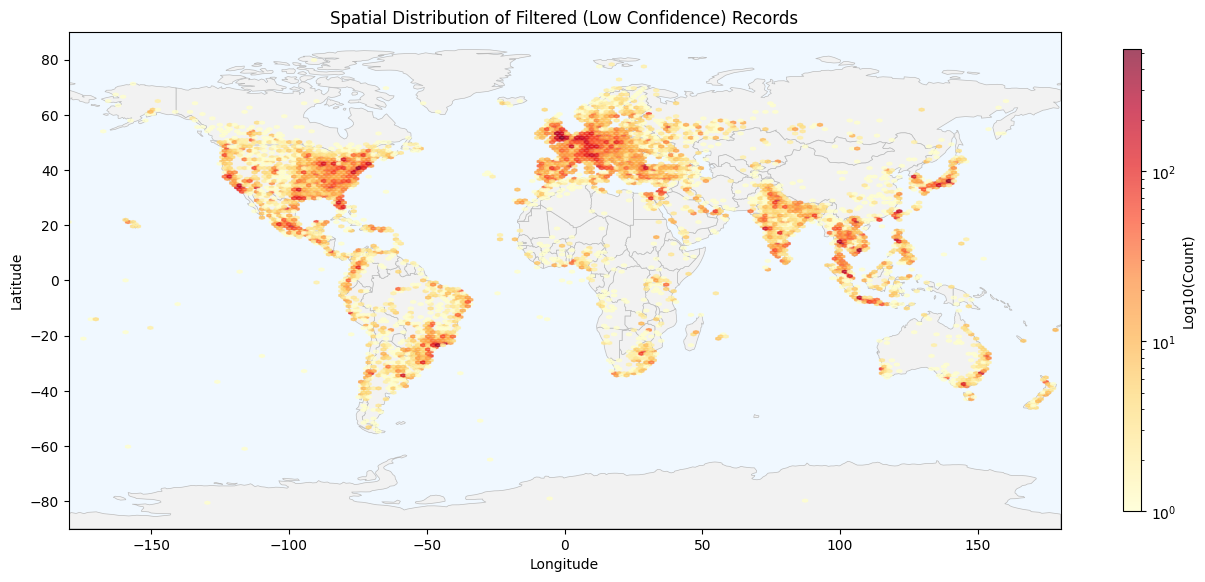

In [0]:
limit_size = 50000
grid_size_val = 200

rejected_sample = valid_coords_df.filter(col("confidence") < CONFIDENCE_THRESHOLD) \
    .select("bbox.xmin", "bbox.ymin") \
    .orderBy(rand()) \
    .limit(limit_size) \
    .toPandas()

fig, ax = plt.subplots(figsize=(16, 10))
try:
    import geopandas as gpd
    world_data_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(world_data_url)
    world.plot(ax=ax, color='#f2f2f2', edgecolor='#bbbbbb', linewidth=0.5)
except Exception as e:
    print(f"Note: World map background could not be loaded ({e}). Plotting data only.")
hb = ax.hexbin(
    rejected_sample['xmin'], 
    rejected_sample['ymin'], 
    gridsize=grid_size_val, 
    cmap='YlOrRd', 
    bins='log',
    mincnt=1,
    alpha=0.7,
    extent=[-180, 180, -90, 90]
)
cb = fig.colorbar(hb, ax=ax, label='Log10(Count)', shrink=0.6, aspect=25)
ax.set_facecolor('#f0f8ff')
ax.set_title('Spatial Distribution of Filtered (Low Confidence) Records')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90])
plt.show()

We analyze confidence scores to determine the optimal threshold that balances data quantity with quality.<br>
By visualizing the distribution and retention rates, we can empirically justify excluding low-confidence records that likely represent data noise or non-existent locations.

---

In [0]:
# Filter out invalid records
high_confidence_df = valid_coords_df.filter(col("confidence") > CONFIDENCE_THRESHOLD)
total_records = high_confidence_df.count()
print(f"Total valid records: {total_records}")

Total valid records: 37944847


## Missing Values

In [0]:
# Count Nulls per column
null_counts_row = high_confidence_df.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in high_confidence_df.columns
]).first()

null_counts_dict = null_counts_row.asDict()

for col_name, missing_count in null_counts_dict.items():
    if missing_count > 0:
        print(f"Column '{col_name}': {missing_count} nulls")
    else:
        print(f"Column '{col_name}': OK (0 nulls)")

Column 'id': OK (0 nulls)
Column 'names': OK (0 nulls)
Column 'categories': OK (0 nulls)
Column 'confidence': OK (0 nulls)
Column 'bbox': OK (0 nulls)
Column 'addresses': OK (0 nulls)
Column 'sources': OK (0 nulls)


## Category Identifier

In [0]:
# Create a category identifier column
df_with_category = high_confidence_df.join(
    broadcast(mapping_df),
    high_confidence_df["categories.primary"] == mapping_df["tag"],
    "inner"
)

## Final Select

In [0]:
# Select columns
final_df = df_with_category.select(
    col("id").alias("place_id"),
    col("names.primary").alias("name"),
    col("categories.primary").alias("subcategory"),
    col("category"),
    col("bbox.ymin").alias("latitude"),
    col("bbox.xmin").alias("longitude"),
    col("addresses")[0].getItem("locality").alias("city"),
    col("addresses")[0].getItem("country").alias("country_code"), 
    col("sources")[0].getItem("dataset").alias("data_source")
).dropDuplicates(["place_id", "category"])

# Save Data

In [0]:
print(f"Saving to unified Delta table: {OUTPUT_TABLE}...")
# Save Data
final_df.write.format("delta") \
    .mode("overwrite") \
    .partitionBy("category") \
    .option("overwriteSchema", "true") \
    .saveAsTable(OUTPUT_TABLE)

# Z-order over coordinates
delta_table = DeltaTable.forName(spark, OUTPUT_TABLE)
delta_table.optimize().executeZOrderBy(["latitude", "longitude"])

count = spark.table(OUTPUT_TABLE).count()
print(f"Saved {count} records to {OUTPUT_TABLE} partitioned by category.")

Saving to unified Delta table: Itav_World_POIs...
Saved 1502390 records to Itav_World_POIs partitioned by category.


# Validation

In [0]:
# Verify results
print("Verifying Output Tables:")

# Load table
loaded_df = spark.table(OUTPUT_TABLE)

for category in CATEGORIES_CONFIG.keys():
    print(f"\nSample data from: {OUTPUT_TABLE} (Category: {category})")
    
    # Filter and display
    display(
        loaded_df
        .filter(col("category") == category)
        .limit(5)
    )

Verifying Output Tables:

Sample data from: Itav_World_POIs (Category: nightlife)


place_id,name,subcategory,category,latitude,longitude,city,country_code,data_source
00011649-9c03-47c3-aa3c-9380df84d177,Tapas & Oyster Bar,bar,nightlife,10.816262,106.73399,Thủ Đức,VN,meta
0001fb1b-fea3-401d-8e01-3845eaf818d9,Birrofficina,bar,nightlife,41.980934,15.005521,Termoli,IT,meta
0003dd9a-e65b-4256-baac-8405bf30f93d,Flappers Comedy Club,comedy_club,nightlife,34.094563,-117.721176,Claremont,US,Microsoft
00049ca5-c5c4-4ac2-9b22-f09a8711ab65,Casa da Sogra,bar,nightlife,-23.585606,-46.805176,São Paulo,BR,meta
00064bbf-c169-403d-b0a6-a41f38fb9a68,Le 22 Bar,bar,nightlife,45.562965,5.9244385,Chambéry,FR,meta



Sample data from: Itav_World_POIs (Category: nature)


place_id,name,subcategory,category,latitude,longitude,city,country_code,data_source
00322bbc-cc2f-498d-ac83-5fa6762d8066,Mendocino Area Parks Association,nature_reserve,nature,39.305325,-123.79729,Mendocino,US,Microsoft
004a7985-90c3-4a1e-ae57-1e882c2115c6,Katiki Water Falls,waterfall,nature,18.279215,82.99883,Araku Valley,IN,meta
0069a256-dc48-48a8-b622-5b68b6c4bcb5,Greeson Nature Reserve,nature_reserve,nature,-32.414406,115.772606,Rockingham,AU,meta
00ac4f2f-d465-4ffd-820f-eb848b7d988f,L.M. Wise Preserve,nature_reserve,nature,42.61479,-85.692566,Hopkins,US,meta
0128773c-2a9d-4ba4-ac9c-d49c838579e7,Waikanae Estuary Scientific Reserve,nature_reserve,nature,-40.878994,175.00058,Paraparaumu,NZ,meta



Sample data from: Itav_World_POIs (Category: tourist)


place_id,name,subcategory,category,latitude,longitude,city,country_code,data_source
00085895-5401-49e5-b68e-b260ed143df0,Palazzo d'Avossa,palace,tourist,40.679646,14.758696,Salerno,IT,meta
00122f46-60c2-4524-9f3d-816b72a2567f,Cabinet Mountains Wilderness,zoo,tourist,48.367744,-115.54371,Libby,US,meta
0029fa16-9094-41b3-9a56-0d5ea0c1356a,Musee de l'illusion Lyon,museum,tourist,45.758915,4.8360868,Lyon,FR,meta
002d2fb0-cc93-4e47-bd48-67dba3d3cdb5,The Rosenbach,museum,tourist,39.947395,-75.17499,Philadelphia,US,meta
00310c96-0a2e-4cee-9862-46cbdda9ff52,Palazzo Chiesa,palace,tourist,45.471138,9.202005,Milano,IT,meta



Sample data from: Itav_World_POIs (Category: shopping)


place_id,name,subcategory,category,latitude,longitude,city,country_code,data_source
00095c5e-f29b-4ffc-8404-c07f82fbd1b8,Delon Moda Casa,department_store,shopping,-23.538786,-46.57584,São Paulo,BR,meta
00265ab5-1c3e-40bf-84c5-86f84f82518f,Đại Lý Tạp Hóa Thảo Thư,department_store,shopping,20.906582,105.6985,Huyện Chương Mỹ,VN,meta
002b5a74-5a36-4509-a400-2160046e0a16,Surtidora Departamental,department_store,shopping,20.67415,-103.34989,Guadalajara,MX,meta
002c8d26-971b-401d-a50c-1d80c6ee67e0,T.J.Maxx,department_store,shopping,26.09452,-80.2469,Davie,US,meta
005168f2-e3bb-415e-8833-d00e9aa0db0d,T.J.Maxx,department_store,shopping,41.95503,-88.71978,Dekalb,US,meta



Sample data from: Itav_World_POIs (Category: relaxation)


place_id,name,subcategory,category,latitude,longitude,city,country_code,data_source
0001116f-528f-427d-aadf-3bd889c383a2,ボディケアサロン アイリフ,beauty_salon,relaxation,35.79845,139.59859,朝霞市,JP,meta
0003bf6f-b3f6-403c-9a07-517bc649bd4f,Allure Chateau Beauty Lounge,beauty_salon,relaxation,51.55151,-0.239515,London,GB,meta
0004a125-3488-432e-9b7e-13086eec14b1,กระท่อมหินนันทภัค โรงแรม แอนด์ รีสอร์ท,resort,relaxation,14.386196,101.85958,วังน้ําเขียว,TH,meta
0004c070-243c-41b9-9fe9-e62a92dd5661,Umut ve Tayfun Kuaför,beauty_salon,relaxation,37.84925,27.840555,Efeler,TR,meta
00056fab-f87d-4a28-8e53-c4ce0b4043c1,Bryant Brothers Hair Styling,beauty_salon,relaxation,32.459114,-93.722496,Shreveport,US,meta
